# Статистическая проверка гипотез

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import scipy
import scipy.stats
import re
from tqdm import tqdm_notebook
from collections import Counter

import matplotlib.pyplot as plt
plt.style.use('ggplot')

np.set_printoptions(precision=4, suppress=True)

## Загрузка данных

In [2]:
%%time
file = 'segmento_log.txt'

data = pd.read_csv(file, 
                   sep='(?:\s?\w+=)|(?:\s#)',
                   header=None,
                   engine='python')
data.head()

CPU times: user 59.3 s, sys: 1.66 s, total: 1min
Wall time: 1min


,0,1,2,3,4,5,6
0,NaN,exp,1,2016-03-03,Browser,2,1
1,NaN,exp,1,2016-03-03,Browser,2,5
2,NaN,exp,1,2016-03-03,Browser,2,1
3,NaN,exp,1,2016-03-03,Browser,2,1
4,NaN,exp,1,2016-03-03,Browser,2,6


In [3]:
#delete NaNs and Browser, assign column names
data.drop(labels=[0,4], axis=1, inplace=True)
columns = re.findall('^(?:\w+)|(?<=\\t)\w+', open(file, 'r').readline())
columns = {k:v for k,v in zip(data.columns, columns)}
data.rename(columns=columns, inplace=True)
data.head()

,slot,userID,ts,browser,all_cl
0,exp,1,2016-03-03,2,1
1,exp,1,2016-03-03,2,5
2,exp,1,2016-03-03,2,1
3,exp,1,2016-03-03,2,1
4,exp,1,2016-03-03,2,6


### описание полей
- Slot - разбиение на А и Б тесты (контроль и эксперимент)
- userID - id пользователя,
- ts - время посещения поисковой страницы
- browser - браузер
- all_cl - общее количество просмотренных страниц на сайте в рамках этой сессии

### Задача
1.1. посчитать среднее количество страниц, которые были просмотрены в рамках одной сессии

1.2. оценить разницу этой метрики между экспериментом и контролем 

1.3. построить для нее доверительный интервал.

2. Посмотреть распределения и особенности пользователей в эксперименте и на контроле.

3. Посмотреть наличие различий по срезам, например, по браузеру. Если есть значимые различия, посчитать метрику - доля пользователей, которые не кликнули ни разу. Сделать выводы

### Порядок решения

1. Для начала нам нужна статистическая модель в виде распределения которое наиболее точно описывает данные. 
2. С помошю найденой стат модели мы можем строить утвержедения с определенной долей вероятности по поводу нахождения наблюдаемых величин в опеределенных пределах.

# Описательные статистики

In [4]:
print(data.shape)
print(data.dtypes)

(6069253, 5)
slot       object
userID      int64
ts         object
browser     int64
all_cl      int64
dtype: object


In [5]:
exp = data.loc[data['slot']=='exp', :]
control = data.loc[data['slot']=='control', :]

print("Размер Эксперимент выборки {0:,d}\nРазмер Контроль выборки {1:,d}\
    \nРазница Эксперимент контроль в % {2:.1f}".format(len(exp), len(control), (len(control)/len(exp)-1)*100))

Размер Эксперимент выборки 2,982,437
Размер Контроль выборки 3,086,816    
Разница Эксперимент контроль в % 3.5


In [6]:
unique_users = len(data['userID'].unique())
feature_intercection_count = lambda x: len(set(exp[x])&(set(control[x])))

descriptive_stat = "Уникальных пользователей {0:,d}, % от всех данных {1:.0f}% \
    \nПересечения пользователей в Контроле и Тесте {2}\
    \nКол-во дней во всех данных {3}, пересечения {4}\
    \nКол-во уникальных браузеров {5}, пересечения {6}".format(
    unique_users, 
    unique_users/len(data)*100,
    feature_intercection_count('userID'),
    len(data['ts'].unique()), 
    feature_intercection_count('userID'),
    len(data['browser'].unique()), feature_intercection_count('browser'))

print(descriptive_stat)

Уникальных пользователей 565,842, % от всех данных 9%     
Пересечения пользователей в Контроле и Тесте 0    
Кол-во дней во всех данных 7, пересечения 0    
Кол-во уникальных браузеров 6, пересечения 6


In [7]:
data['ts'].unique()

array(['2016-03-03', '2016-02-26', '2016-03-01', '2016-02-29',
       '2016-02-28', '2016-02-27', '2016-03-02'], dtype=object)

In [8]:
data['browser'].unique()

array([ 2,  4, 14, 17, 20, 22])

In [9]:
print("Кол-во пропущенных значений =", data.isna().sum().sum())

Кол-во пропущенных значений = 0


## Разведочный анализ

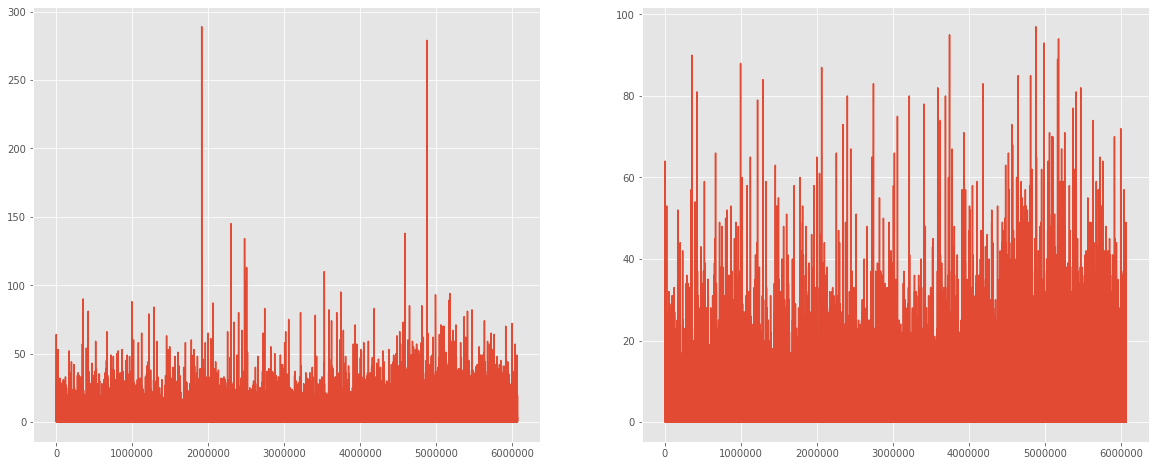

In [10]:
_, ax = plt.subplots(1,2, figsize=(20,8))
ax[0].plot(data['all_cl'])
ax[1].plot(data.loc[data['all_cl']<100, ['all_cl']])
plt.show()

#### Просмотры страниц имеют разную вариацию, которая растет к концу периода датасета

In [11]:
data[['slot','browser', 'ts']] = data[['slot', 'browser', 'ts']].astype('category')

In [12]:
def plot_violin(x, y, category, data, title):
    "построение гистограмм распределений с группировкой"
    
    import seaborn as sns
    _, ax = plt.subplots(figsize=(20,8))
    sns.violinplot(x=x, y=y, hue=category, data=data,
                   split=True, 
                   ax=ax)

    sns.despine(left=True)
    plt.title(title)

/home/protus/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CPU times: user 1min 40s, sys: 1min 42s, total: 3min 23s
Wall time: 27.1 s


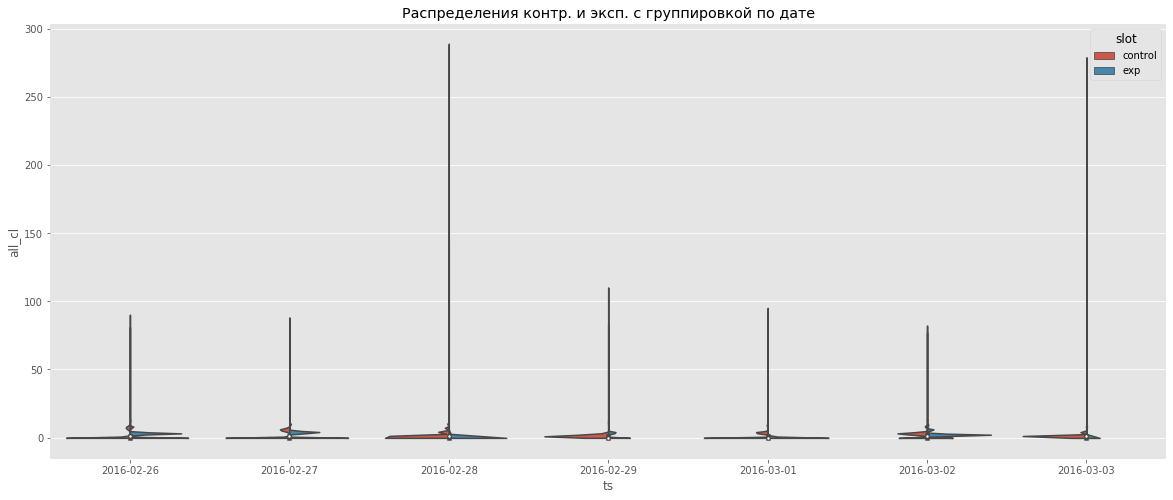

In [13]:
%%time
plot_violin(x='ts', y='all_cl', category='slot', data=data, 
            title='Распределения контр. и эксп. с группировкой по дате')

In [14]:
#определяем выбросы
outlier_threshold = np.percentile(data['all_cl'], 99)
print("99% значений находятся в пределах до =", outlier_threshold)

99% значений находятся в пределах до = 7.0


CPU times: user 1min 56s, sys: 2min 4s, total: 4min
Wall time: 32.2 s


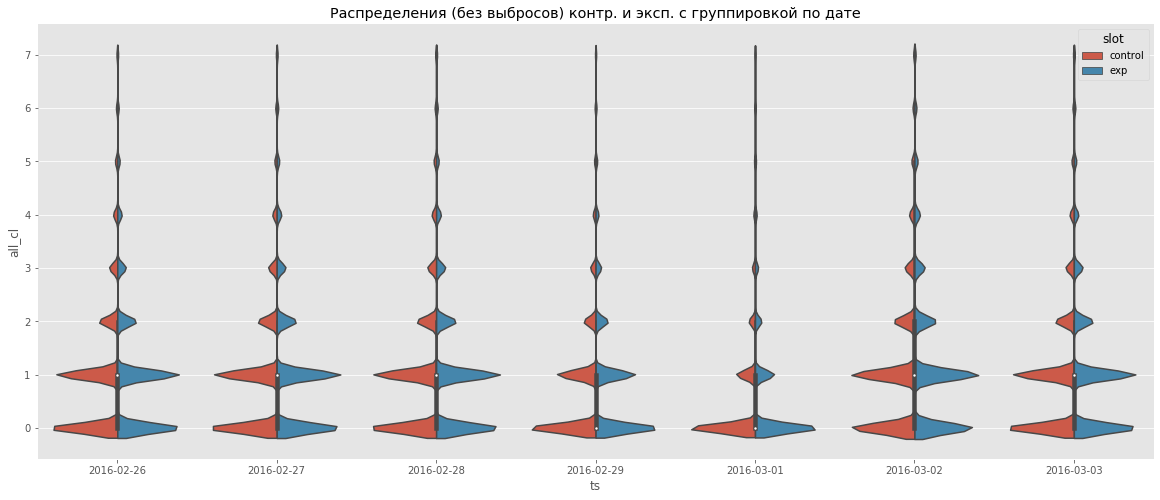

In [15]:
%%time
plot_violin(x='ts', y='all_cl', category='slot', data=data.loc[data['all_cl']<=outlier_threshold, :],
            title='Распределения (без выбросов) контр. и эксп. с группировкой по дате')

#### В целом, по характеру распределения существенных различий в группировке по датам не наблюдается. 
- Есть небольшое отклонение в "2016-03-01" . 
- Различий так же невидно в срезе Контроль/Эксперимент

CPU times: user 2min, sys: 2min 3s, total: 4min 3s
Wall time: 33.2 s


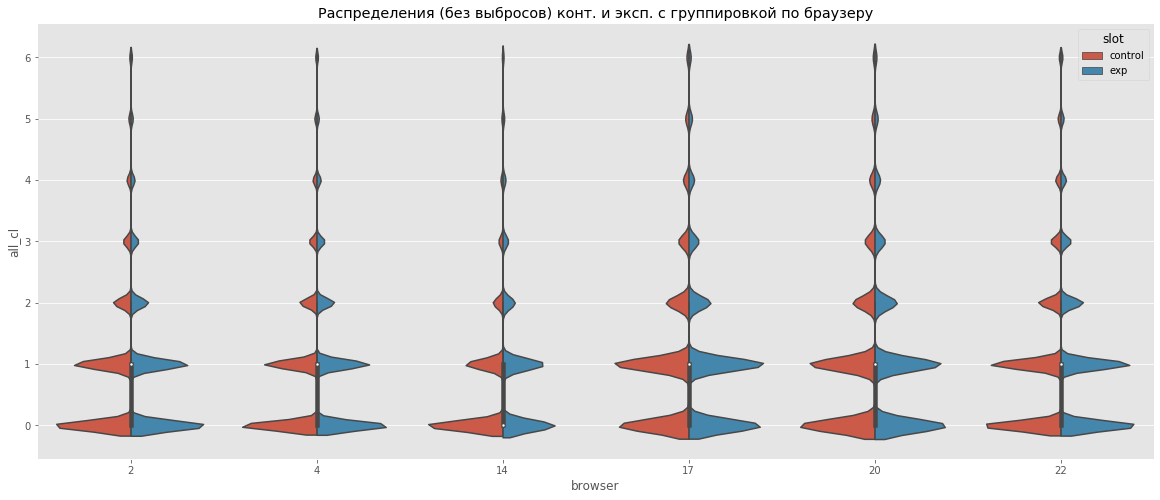

In [16]:
%%time
plot_violin(x='browser', y='all_cl', category='slot', data=data.loc[data['all_cl']<outlier_threshold, :],
           title='Распределения (без выбросов) конт. и эксп. с группировкой по браузеру')

#### В группировке по браузеру характер распределения в большинстве случаев схож. Наблюдается несущественные отклонения: 
- в 14 браузере на контроле кол-во некликнувших имеет выраженную островершинность и меньшую вариацию по сравнению с экспериментом
- в 17 браузере кол-во кликнувших имеет бОльшую частоту по сравнению с некликнувшими, в остальных браузерах наблюдается обратная картина 

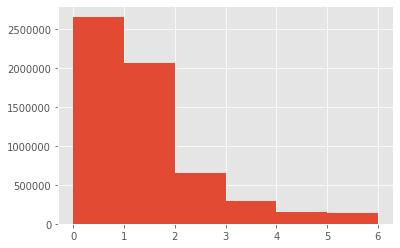

In [17]:
data.loc[data['all_cl']<outlier_threshold, 'all_cl'].hist(bins=6)

##### общий вид  частот просмотров страницы напоминает экспоненциальное распределение

#### Выводы 
- Имеем практически <b>одинаковые по размеру выборки</b> Эксперимент/Контроль
- В Контроле и Эксперименте <b>разные пользователи</b> - которые непересакаются, значит выборки независимые
- В Контроле и Эксперименте данные представлены за <b>разные непересекающиеся периоды</b>
- В Контроле и Эксперименте <b>данные представленны по всем браузерам</b>
- 91% данных в выборке представлено по одним и тем же пользователям лишь 9% пользователей уникальны 
- Просмотры страниц имеют разную вариацию, которая растет к концу периода датасета
- Пропущеных значений нет

### В следующей части анализа попытаемся опровергнуть или подтвердить эти наблюдения.

## Выбор метрики

### 1.1. посчитать среднее количество страниц, которые были просмотрены в рамках одной сессии

In [18]:
def select_means_between_thresholds(x, down, up):
    """группировка по пользователям 
    с усреднением, с последующим исключением 
    по границам значений"""
    
    res = x.groupby(by='userID').mean()
    return res.loc[ (res['all_cl']>down) & (res['all_cl']<up), ['all_cl']].values

In [19]:
def plot_two_hist(data1, data2, bins=50):
    _, ax = plt.subplots(1,2, figsize=(20,5))
    ax[0].hist(data1, bins=bins)
    ax[1].hist(data2, bins=bins)

Выборочное Среднее эксперимет: 1.216     
Выборочное Среднее контроль:   1.163


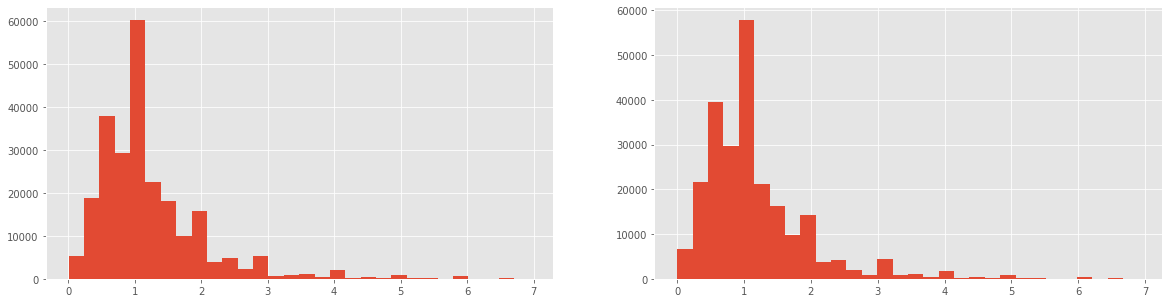

In [20]:
#считаем среднее кол-во просмотров по каждому пользователю,
#выбираем только тех пользователей которые осуществили переход по ссылке
#т.е. те пользователи у которых были просмотры

mean_exp_views = select_means_between_thresholds(exp, 0, outlier_threshold)
mean_control_views = select_means_between_thresholds(control, 0, outlier_threshold)

print('Выборочное Среднее эксперимет: {0:.3f}\
     \nВыборочное Среднее контроль:   {1:.3f}'
      .format(np.mean(mean_exp_views), np.mean(mean_control_views)))

plot_two_hist(mean_exp_views, mean_control_views, bins=30)

- распределения среднего кол-ва просмотров по пользователяем в тестовой и контрольной выборке 
имеет уже выраженную логнормальность
- отличия контроля и теста не видны

## Выбор стат. модели

#### проверка распределения и проведение статистического теста

In [21]:
def fit_distribution(x, bins=10, distr_type='norm'):
    """подгонка теоретического распределения под эмпирическое"""
    
    dist = getattr(scipy.stats, distr_type)
    params = dist.fit(x)
    x_norm = np.linspace(min(x), max(x), bins)
    y = dist.pdf(x_norm, *params)
    
    return y, params

def fit_test_plot(x, bins, distr_type, ax, bin_edges, hist=None):
    """Подгонка распределения, К-С_тест, отрисовка графика"""
    
    y, params = fit_distribution(x, bins, distr_type=distr_type)
    #Kolmogorv-Smirnov test
    D, p_val = scipy.stats.ks_2samp(hist, y.flatten())
    RMSE = np.sum(np.power(hist - y.flatten(), 2.0)/len(bin_edges))
    label = 'p-level {0:.5f} D {1:.3f},  RMSE {2:.3f} of {3} distribution'.format(p_val, D, RMSE, distr_type)
    ax.plot(bin_edges[:-1], y, label=label)
    
    return y, params


def hist_of_true_theor(x, distr_type=None, bins=10,):
    """Вывод на график фактического и теоретических
    распределение с результатами теста"""
    
    hist, bin_edges = np.histogram(x, bins=bins, density=True)
    
    fig, ax = plt.subplots(1, 1, figsize=(20,8))
    ax.bar(bin_edges[:-1], hist, width=bin_edges[-1]/len(bin_edges[:-1]), alpha=0.3)
    
    y, params = None, None
    
    if not distr_type:
        distr_type = ['norm','lognorm','expon','weibull_min']

        for dist in tqdm_notebook(distr_type):
            fit_test_plot(x, bins, dist, ax, bin_edges, hist)
    else:
        y, params = fit_test_plot(x, bins, distr_type, ax, bin_edges, hist)
    
    plt.legend(loc='upper right', prop={'size': 14})
    
    return y, params

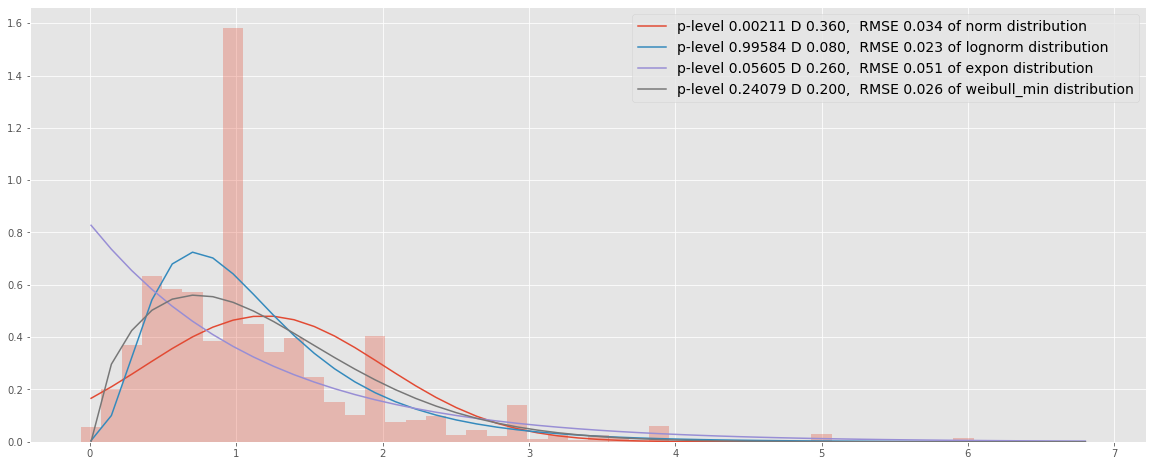

In [22]:
BINS = 50
_, _ = hist_of_true_theor(mean_exp_views, bins=BINS)

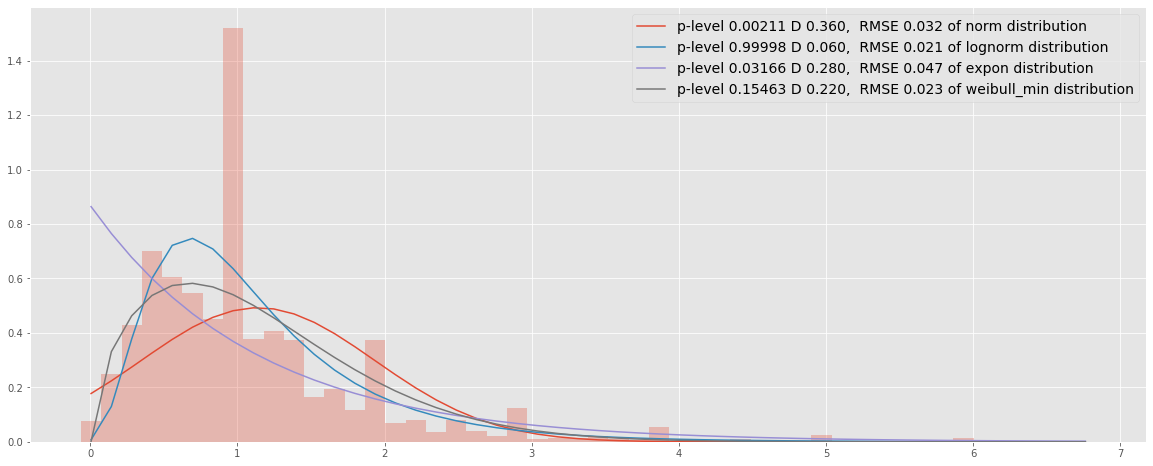

In [23]:
_, _ = hist_of_true_theor(mean_control_views, bins=BINS)

- видим, что в качестве статистической модели распределения <b>наиболее подходит Логнормальное распределение</b> 
- в качестве критерия согласованности используем непараметрический тест Колмогорова Смирнова, согласно которому теоретическое логнормальное распределение имеет самое меньшее расхождение с фактическим распределением из рассматриваемых распределений, к томуже <b>гипотеза о равенстве этих распределениий статистически значима и неотвергнута.</b>
- так же логнормальное теоретическое распределение <b>имеет наименьшую ошибку</b> по сравнению с другими распределениями
- это относиться как к тесту так и эксперименту

- воспользуемся свойством логнормального распределения: <b>"Если случайная величина имеет логнормальное распределение, то её логарифм имеет нормальное распределение"</b>

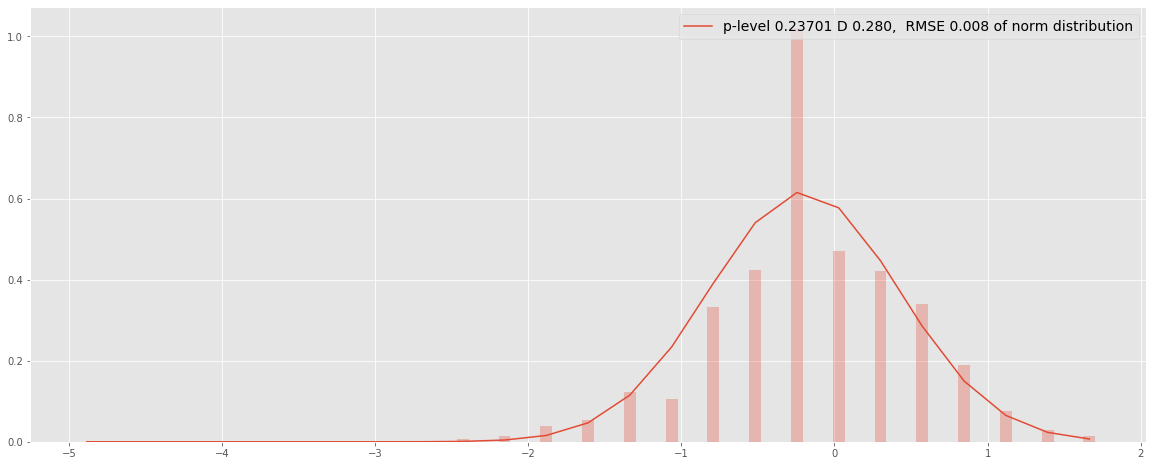

In [24]:
exp_y, exp_params = hist_of_true_theor(np.log(mean_exp_views), bins=25, distr_type='norm')

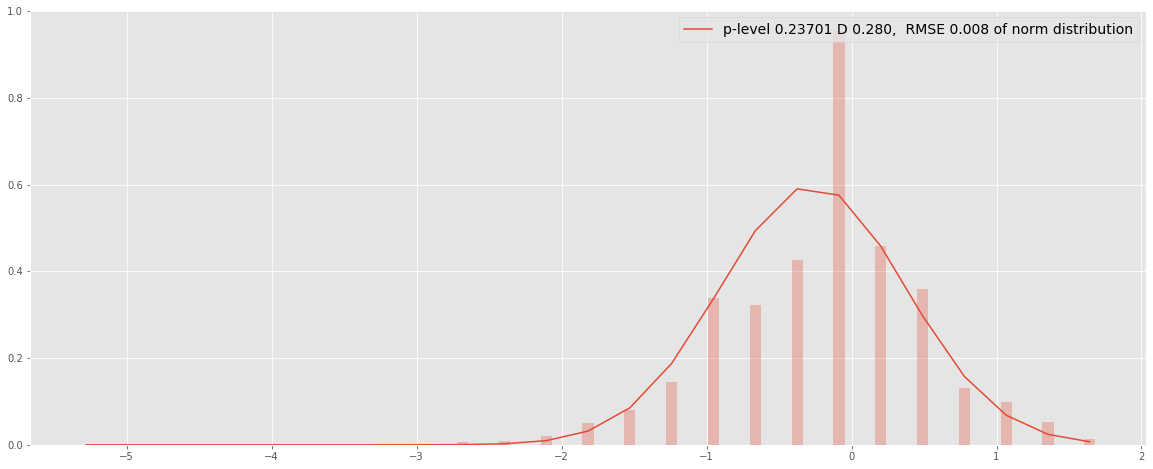

In [25]:
control_y, control_params = hist_of_true_theor(np.log(mean_control_views), bins=25, distr_type='norm')

- тесты снова показали значимый результат и верность Нулевой гипотезы о равенстве нормального теоретического и фактического распределений

### 1.2. оценить разницу этой метрики между экспериментом и контролем

- на этапе разведочного анализа мы увидели что вариации немного различаются, проведем тест и проверим значимо ли это различие, для проведения корректного сравнения

In [26]:
b_stat, p_value = scipy.stats.bartlett(exp_y, control_y)
print("Значимость различий дисперсий p_val:", p_value)

Значимость различий дисперсий p_val: 0.8606244686767599


- гипотеза о равенстве дисперсий не отвергнута
- значит существенных различий в вариациях нет

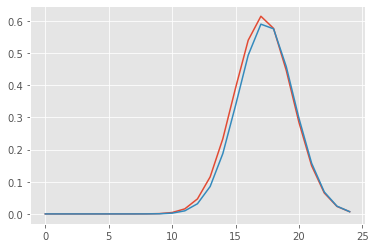

In [27]:
_, ax = plt.subplots()
ax.plot(exp_y)
ax.plot(control_y)

In [28]:
#t-критерий Стьюдента
t, p_value = scipy.stats.ttest_ind(exp_y, control_y)
print("Значимость Т критерия Стьюдента", p_value)

Значимость Т критерия Стьюдента [0.896]


- Проверка гипотезы о равенстве средних по Т криетерию Стьюдента не отклонило нулевую H0 гипотезу о равенстве средних, т.к. 
- p-value 0,9082 что означает значимой разници между средними контроль/тест нет

### Вывод: различия средних Контроля и Эксперимента несущественны

### 1.3. построить доверительный интервал для среднего значения

In [29]:
conf_int = np.exp(scipy.stats.norm.interval(0.95, *exp_params))
print('Доверительный интервал для средней эксперимента {0:.3f} сотавляет: от  {1:.3f} до {2:.3f}'.\
      format(np.exp(np.mean(exp_y)), conf_int[0], conf_int[1]))

Доверительный интервал для средней эксперимента 1.151 сотавляет: от  0.280 до 3.543


In [30]:
y_log, par = fit_distribution(mean_exp_views, bins=25, distr_type='lognorm')
scipy.stats.lognorm.mean(*par)

1.212095596093484

In [31]:
scipy.stats.lognorm.interval(0.95,*par)

(0.257260217795389, 3.2453507945919458)

In [32]:
scipy.stats.lognorm.ppf(0.95, *par)

2.7137967583519456

In [33]:
scipy.stats.lognorm.ppf(0.05, *par)

0.3331451499835639

In [34]:
np.exp(np.mean(np.log(mean_control_views))+np.std(np.log(mean_control_views))**2/2)

1.1783748758113988

In [35]:
plt.hist(true_dist, cumulative=True, bins=30, histtype='step', alpha=0.8, color='r')
plt.hist(exp_dist, cumulative=True, bins=30, histtype='step', alpha=0.8, color='b')
theor_distr, params  = fit_distribution(inputs, bins=30, distr_type='norm')
plt.hist(theor_distr, cumulative=True, bins=30, histtype='step', alpha=0.8, color='g')
plt.show()

NameError: name 'true_dist' is not defined

In [ ]:
#классификация пользователей